In [1]:
import numpy as np
import networkx as nx
import kmapper as km
import sklearn
import warnings
import matplotlib.pyplot as plt
import signal
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms.similarity import graph_edit_distance
import math
import statistics

warnings.filterwarnings("ignore")

In [2]:
def select_k(spectrum, minimum_energy = 0.9):
    running_total = 0.0 
    
    total = sum(spectrum)
    if total == 0.0:
        return len(spectrum)
    for i in range(len(spectrum)):
        running_total += spectrum[i]
        if running_total / total >= minimum_energy:
            return i + 1
    return len(spectrum)

In [3]:
def calculate_similarity(graph1,graph2):
    laplacian1 = nx.spectrum.laplacian_spectrum(graph1)
    laplacian2 = nx.spectrum.laplacian_spectrum(graph2)
    
    k1 = select_k(laplacian1)
    k2 = select_k(laplacian2)
    k = min(k1, k2) #k are different between the two graphs, then use the smaller one.
    similarity = sum((laplacian1[:k] - laplacian2[:k])**2) #sum of the squared differences between the largest k eigenvalues
    return similarity

In [4]:
def extract_graph_features(graph):
    pr = nx.pagerank(graph,0.9)
    dc = nx.degree_centrality(graph)
    cc = nx.closeness_centrality(graph)
    bx = nx.betweenness_centrality(graph)
    c = nx.clustering(graph)
    
    #create list for each features
    pr_list =  [i for i in pr.values()]
    dc_list =  [i for i in dc.values()]
    cc_list =  [i for i in cc.values()]
    bx_list =  [i for i in bx.values()]
    c_list =  [i for i in c.values()]
    d_list = [val for (node, val) in graph.degree()]
    data = np.column_stack((pr_list,dc_list,cc_list,bx_list,c_list,d_list))
    return data

In [5]:
def TDA_transformation(data):
    Xfilt = data
    mapper = km.KeplerMapper()
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    Xfilt = scaler.fit_transform(Xfilt)
    lens = mapper.fit_transform(Xfilt, projection=sklearn.manifold.TSNE())
    cls = 5  # We use cls= 5

    graph = mapper.map(lens,Xfilt,clusterer=sklearn.cluster.KMeans(n_clusters=cls,random_state=1618033),
        cover=km.Cover(n_cubes=2, perc_overlap=0.7)) #2 - 0.3
    return km.to_nx(graph)

In [6]:
def calc_average_for_hop(hop,ref_graph,n,p,delta_n,delta_p):
    original = []
    TDA =[]
    
    for i in range(-hop,hop + 1):
        for j in range(-hop,hop + 1):
            if (i == -hop or i == hop or j == -hop or j == hop):
                neighbour = nx.erdos_renyi_graph(i*delta_n + n,j*delta_p + p)
                TDA_graph = TDA_transformation(extract_graph_features(ref_graph))
                TDA_neighbour = TDA_transformation(extract_graph_features(neighbour))
                
                score_TDA = calculate_similarity(TDA_graph, TDA_neighbour)
                score_original = calculate_similarity(ref_graph, neighbour)
                
                original.append(score_original)
                TDA.append(score_TDA)
    return {"hop" : hop,"TDA": statistics.median(TDA),"original": statistics.median(original),"TDA-list" : TDA,"original-list":original}
                

In [7]:
def conduct_test_for_on_graph(graph,n,p,delta_n,delta_p,n_hop):
    result = [dict() for x in range(n_hop)]
    for i in range(n_hop):
        result[i] = calc_average_for_hop(hop =i+1,ref_graph = graph,n = n,p = p,delta_n = delta_n,delta_p = delta_p)
        print(result[i])
    return {"n" : n,"p" : p,"Result" : result}
    

In [8]:
graph = nx.erdos_renyi_graph(30,0.4)
result = conduct_test_for_on_graph(graph,30,0.4,1,0.05,4)
result

{'hop': 1, 'TDA': 0.0, 'original': 35.979952345078345, 'TDA-list': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'original-list': [88.56458417080879, 39.82681867293023, 182.8724223585049, 163.03929161209714, 26.312651333107418, 19.636943006421816, 24.662711558874985, 32.13308601722646]}
{'hop': 2, 'TDA': 0.0, 'original': 149.79826889970406, 'TDA-list': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'original-list': [314.2372789987969, 141.6808251486604, 16.20640904294972, 13.789517737401543, 209.53647563693747, 256.04149399704903, 157.91571265074768, 285.0474780101016, 279.7905366834136, 313.6032310433281, 116.66295245025577, 115.54697450343339, 12.624288703669315, 18.160111192153533, 109.27998718192559, 406.2903703952582]}
{'hop': 3, 'TDA': 0.0, 'original': 316.5956068813465, 'TDA-list': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'original-list': [300.330564094586, 398.8523434

{'n': 30,
 'p': 0.4,
 'Result': [{'hop': 1,
   'TDA': 0.0,
   'original': 35.979952345078345,
   'TDA-list': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   'original-list': [88.56458417080879,
    39.82681867293023,
    182.8724223585049,
    163.03929161209714,
    26.312651333107418,
    19.636943006421816,
    24.662711558874985,
    32.13308601722646]},
  {'hop': 2,
   'TDA': 0.0,
   'original': 149.79826889970406,
   'TDA-list': [0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0],
   'original-list': [314.2372789987969,
    141.6808251486604,
    16.20640904294972,
    13.789517737401543,
    209.53647563693747,
    256.04149399704903,
    157.91571265074768,
    285.0474780101016,
    279.7905366834136,
    313.6032310433281,
    116.66295245025577,
    115.54697450343339,
    12.624288703669315,
    18.160111192153533,
    109.27998718192559,
    406.2903703952582]},
  {'hop': 3,
   'TDA': 0.0

In [105]:
def conduct_test_on_sample(sample_numbers,n_hop):
    column = []
    row_list = []
    column.append('n')
    column.append('p')
    
    detail_row_list = []
    detail_column = ['Sample','Replication', 'n','p','Hop','Neigbour Index','Original','TDA']
    
    for i in range(n_hop):
        original_text = "Original_"
        TDA_text = "TDA_"
        original_text = original_text + str(i+1)
        TDA_text = TDA_text + str(i+1)
        column.append(original_text)
        column.append(TDA_text)
        
    for i in range(sample_numbers):
        n = random.randint(30,50)       
        p = round(random.uniform(21, 40))/100
        for k in range(5):
            row =[]

            row.append(n)
            row.append(p)
            reference_graph = nx.erdos_renyi_graph(n,p)
            result = conduct_test_for_on_graph(reference_graph,n,p,2,0.05,n_hop)['Result']

            for j in range(n_hop):
                row.append(result[j]['original'])
                row.append(result[j]['TDA'])
                
                TDA_list = result[j]['TDA-list']
                original_list = result[j]['original-list']
                for t in range(len(TDA_list)):
                    detail_row = []
                    detail_row.append(i+1)
                    detail_row.append(k + 1)
                    detail_row.append(n)
                    detail_row.append(p)
                    detail_row.append(j+1)
                    detail_row.append("neighbour_" + str(t+1))
                    detail_row.append(round(original_list[t],2))
                    detail_row.append(round(TDA_list[t],2))
                    detail_row_list.append(detail_row)
            print("Done " + str(i+1) + "/" + str(sample_numbers))
            row_list.append(row)
 
    
    df = pd.DataFrame(row_list,columns= column)
    df_detail = pd.DataFrame(detail_row_list,columns=detail_column)
    result = {"result" : df, "detail" : df_detail}
    return result
        

In [63]:
result_all = conduct_test_on_sample(50,4)


['n', 'p', 'Original_1', 'TDA_1', 'Original_2', 'TDA_2', 'Original_3', 'TDA_3', 'Original_4', 'TDA_4']


In [64]:
result_all['result'].to_csv("ER.csv")
result_all['detail'].to_csv("ER-detail.csv")

In [66]:
df = result_all['result']
df

,n,p,Original_1,TDA_1,Original_2,TDA_2,Original_3,TDA_3,Original_4,TDA_4
0,50,0.36,293.617294,11.853289,809.504384,11.414586,1938.571756,8.077321,2974.218485,7.838016
1,50,0.36,175.822067,7.351832,854.739849,9.513129,1872.220237,8.930714,2838.095692,8.702884
2,50,0.36,319.652848,7.889936,638.565809,8.749274,1937.087557,12.765388,2707.553420,11.103834
3,50,0.36,171.564943,10.649038,893.983730,6.927425,1874.762450,7.693352,3264.946046,6.009919
4,50,0.36,284.274688,8.369293,845.255635,13.734026,1937.742654,7.626318,3271.397538,9.296393
...,...,...,...,...,...,...,...,...,...,...
145,47,0.39,93.198044,12.046715,519.211507,10.753855,1498.600925,10.968695,2687.371514,9.916790
146,47,0.39,243.097413,8.496967,490.367882,8.584842,1494.947905,7.389579,2599.339262,11.554975
147,47,0.39,125.103634,11.765366,631.018675,6.154195,1637.221937,10.320974,2394.450554,7.724594
148,47,0.39,237.193204,8.235433,708.299210,10.854604,1169.902358,6.259716,2440.302418,8.081096


In [48]:
df.to_csv("30_sample_graphs-ER.csv")

In [49]:
df

,n,p,Original_1,TDA_1,Original_2,TDA_2,Original_3,TDA_3,Original_4,TDA_4
0,43,0.36,246.834363,7.757776,530.146686,7.549241,1214.392091,11.320279,1991.314007,12.608134
1,38,0.34,109.349541,12.445517,372.685176,13.084302,848.019708,11.007104,1479.288875,12.461456
2,42,0.28,144.218566,10.510292,516.416411,9.715655,945.599280,11.852701,1854.003271,12.090326
3,46,0.29,193.404144,6.636335,593.955392,11.147578,1334.977459,12.118363,2399.556685,10.629082
4,44,0.29,160.258000,10.424263,545.690410,17.880047,1224.164363,14.310623,2012.156552,10.477194
5,49,0.31,317.015239,8.752992,901.791019,13.089569,1766.361636,12.541958,3009.327403,11.258657
6,47,0.22,227.596789,10.518089,727.158419,10.137342,1362.045862,9.292534,2592.644157,15.035428
7,45,0.38,181.024641,15.025286,618.810692,7.805347,1302.409346,10.125338,2227.295456,10.637895
8,45,0.24,168.989990,11.834480,564.814327,10.277094,1364.729941,12.425913,2147.085251,11.277626
9,33,0.34,117.902655,8.786017,235.157158,12.661404,498.314490,10.736076,887.554974,12.078992


In [3]:

df_read = pd.read_csv('ER-fail.csv',index_col=False)
df_read.drop(columns=['Unnamed: 0'])

,n,p,Original_1,TDA_1,Original_2,TDA_2,Original_3,TDA_3,Original_4,TDA_4
0,47,0.36,149.087171,69.059983,823.359569,64.560074,1758.296144,75.795621,2731.437793,69.097877
1,47,0.36,172.684468,45.113214,534.310922,75.338507,1545.149337,58.862983,2495.157448,101.403085
2,47,0.36,162.619518,70.392380,773.936914,40.265263,1482.075933,53.617979,2511.344838,75.536897
3,47,0.36,75.683356,78.667928,556.471076,84.723924,1302.805265,66.075318,2446.517588,76.112240
4,47,0.36,109.955080,106.526758,658.626822,102.241346,1319.398583,69.984387,2723.697883,75.757828
...,...,...,...,...,...,...,...,...,...,...
245,39,0.33,95.388341,67.287829,434.519192,82.523754,1088.999105,75.654064,1585.597150,69.365895
246,39,0.33,145.318794,97.954154,270.167056,81.212236,893.458854,104.402782,1325.183041,75.395661
247,39,0.33,61.912702,57.190224,376.882330,89.649487,758.257360,80.841376,1321.290214,89.660099
248,39,0.33,197.313384,45.711936,288.231228,96.188068,912.050390,62.559321,1450.180543,94.850170


In [15]:
original_average =[]
TDA_avaerage = []
std_original = []
std_TDA = []
median_TDA = []
median_original =[]
median_TDA_log = []
median_original_log = []

for i in range(4):
    original_text = "Original_" + str(i+1)
    TDA_text = "TDA_" + str(i+1)
    original_list = df_read[original_text].tolist()
    tda_list = df_read[TDA_text].tolist()
    
    std_original.append(round(statistics.stdev(original_list),2))
    std_TDA.append(round(statistics.stdev(tda_list),2))
    
    median_original.append(round(statistics.median(original_list),4))
    median_TDA.append(round(statistics.median(tda_list),4))
    
    median_original_log.append(round(math.log10(statistics.median(original_list)),4))
    median_TDA_log.append(round(math.log10(statistics.median(tda_list)),4))
    original_sum = 0
    tda_sum = 0
    for j in range(len(original_list)):
        original_sum = original_sum + original_list[j]
        tda_sum = tda_sum + tda_list[j]
#     original_average.append(round(math.log10(original_sum/len(original_list)),4))
#     TDA_avaerage.append(round(math.log10(tda_sum/len(tda_list)),4))
    original_average.append(round(original_sum/len(original_list),4))
    TDA_avaerage.append(round(tda_sum/len(tda_list),4))
#     TDA_avaerage.append(round(tda_sum/len(tda_list),2))
  
        

In [25]:
original_average

[130.8884, 475.6168, 1080.6989, 1885.6125]

In [26]:
TDA_avaerage

[80.1757, 80.908, 86.8088, 95.2719]

In [ ]:
mea

In [6]:
std_original_log = []
std_TDA_log = []
for i in range(4):
    original_text = "Original_" + str(i+1)
    TDA_text = "TDA_" + str(i+1)
    original_list = df_read[original_text].tolist()
    tda_list = df_read[TDA_text].tolist()
    for j in range(len(original_list)):
        original_list[j] = math.log10(original_list[j])
        tda_list[j] = math.log10(tda_list[j])
    std_original_log.append(round(statistics.stdev(original_list),2))
    std_TDA_log.append(round(statistics.stdev(tda_list),2))

In [30]:
std_original_log

[0.23, 0.21, 0.2, 0.19]

In [31]:
std_TDA_log

[0.16, 0.14, 0.12, 0.14]

In [20]:
median_TDA

[75.5544, 74.5388, 81.7696, 88.4441]

In [27]:
median_original

[125.5864, 482.5665, 1092.2351, 1926.6761]

In [22]:
median_TDA

[75.5544, 74.5388, 81.7696, 88.4441]

In [28]:
median_TDA_log

[1.8783, 1.8724, 1.9126, 1.9467]

In [29]:
median_original_log

[2.0989, 2.6836, 3.0383, 3.2848]

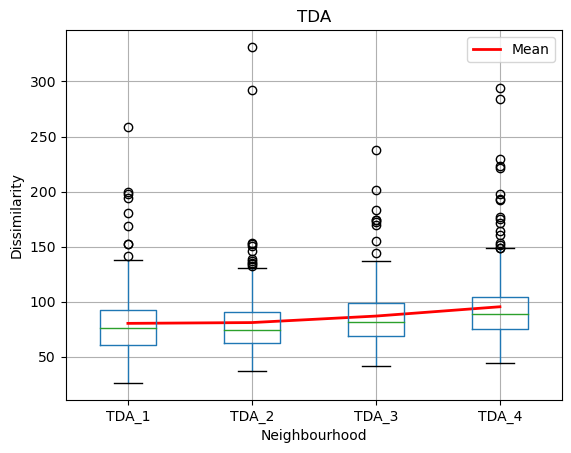

<Figure size 640x480 with 0 Axes>

In [12]:

# boxplot_original = df_read.boxplot(column=['Original_1', 'Original_2', 'Original_3','Original_4])  

plt.plot(np.arange(len(TDA_avaerage)) + 1, TDA_avaerage,linewidth=2, markersize=12,color='red',label ="Mean")
boxplot_TDA = df_read.boxplot(column=['TDA_1', 'TDA_2', 'TDA_3','TDA_4']) 
plt.xlabel('Neighbourhood')
plt.ylabel('Dissimilarity')
plt.title("TDA")
plt.legend()
plt.show()
plt.savefig("TDA-ER.jpg")

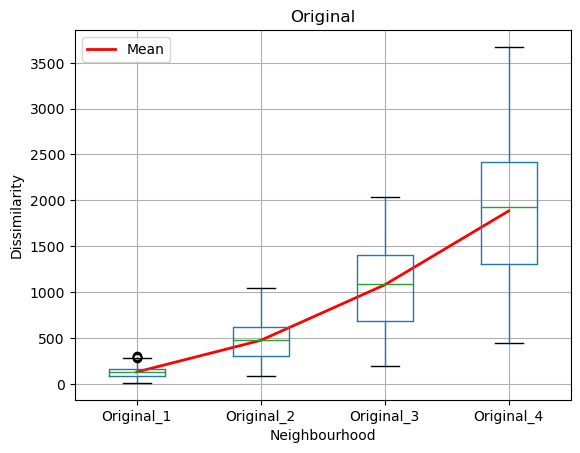

In [32]:
plt.plot(np.arange(len(original_average)) + 1, original_average,linewidth=2, markersize=12,color='red',label ="Mean")
boxplot_original = df_read.boxplot(column=['Original_1', 'Original_2', 'Original_3','Original_4']) 
plt.xlabel('Neighbourhood')
plt.ylabel('Dissimilarity')
plt.title("Original")
plt.legend()
plt.show()

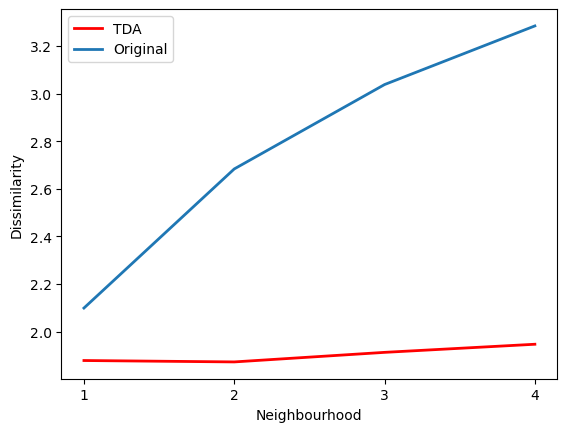

In [34]:
hop = ['1','2','3','4']
plt.plot(hop, median_TDA_log,linewidth=2, markersize=12,color='red',label ="TDA")
plt.plot(hop, median_original_log,linewidth=2, markersize=12, label="Original")
plt.xlabel('Neighbourhood')
plt.ylabel('Dissimilarity')
plt.legend()
plt.savefig("TDA-Original-ER.jpg")
plt.show()